In [1]:
%matplotlib inline

# Imports
import matplotlib.pyplot as plt
import gc
import statsmodels.stats.proportion

# seaborn
import seaborn
seaborn.set()
seaborn.set_style("darkgrid")

# Project imports
from model import *

In [2]:
# Get raw data
raw_data = get_raw_scdb_data("../data/input/SCDB_Legacy_01_justiceCentered_Citation.csv")

# Get feature data
feature_df = preprocess_raw_data(raw_data, include_direction=True)

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py:2825: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
# Output some diagnostics on features
print(raw_data.shape)
print(feature_df.shape)
assert(raw_data.shape[0] == feature_df.shape[0])

(249793, 82)
(249793, 1725)


In [4]:
# Output basic quantities for sample
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts()))
print(pandas.DataFrame(raw_data["justice_outcome_disposition"].value_counts(normalize=True)))

    justice_outcome_disposition
 0                       114780
 1                        94505
-1                        40508
    justice_outcome_disposition
 0                     0.459500
 1                     0.378333
-1                     0.162166


In [5]:
# Setup training time period
dummy_window = 1000
min_training_years = 50
term_range = range(raw_data["term"].min() + min_training_years,
                   raw_data["term"].max()+1)

# Setting growing random forest parameters
# Number of trees to grow per term
trees_per_term = 2

# Number of trees to begin with
initial_trees = min_training_years * trees_per_term

# Number of years between "forest fires"
reset_interval = 9999

# Setup model
m = None
term_count = 0

for term in term_range:
    # Diagnostic output
    print("Term: {0}".format(term))
    term_count += 1
    
    # Setup train and test periods
    train_index = (raw_data.loc[:, "term"] < term).values
    test_index = (raw_data.loc[:, "term"] == term).values
    
    # Setup train data
    feature_data_train = feature_df.loc[train_index, :]
    target_data_train = raw_data.loc[train_index, "justice_outcome_disposition"].astype(int).values

    # Setup test data
    feature_data_test = feature_df.loc[test_index, :]
    target_data_test = raw_data.loc[test_index, "justice_outcome_disposition"].astype(int).values
    
    # Check if we should rebuild the model based on changing natural court
    if term_count % reset_interval == 0:
        # "Forest fire;" grow a new forest from scratch
        print("Reset interval hit; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        m = None
    else:
        # Check if the justice set has changed
        if set(raw_data.loc[raw_data.loc[:, "term"] == (term-1), "justice"].unique()) != \
            set(raw_data.loc[raw_data.loc[:, "term"] == (term), "justice"].unique()):
            # natural Court change; trigger forest fire
            print("Natural court change; rebuilding with {0} trees".format(initial_trees + (term_count * trees_per_term)))
        
            m = None
                                              
    # Build or grow a model depending on initial/reset condition
    if not m:
        # Grow an initial forest
        m = sklearn.ensemble.RandomForestClassifier(n_estimators=initial_trees + (term_count * trees_per_term), 
                                                    #class_weight="balanced_subsample",
                                                    warm_start=True,
                                                    n_jobs=-1)
    else:
        # Grow the forest by increasing the number of trees (requires warm_start=True)
        m.set_params(n_estimators=initial_trees + (term_count * trees_per_term))

    # Fit the forest model
    m.fit(feature_data_train,
          target_data_train)

    # Fit the "dummy" model
    d = sklearn.dummy.DummyClassifier(strategy="most_frequent")
    d.fit(feature_data_train.tail(dummy_window), pandas.Series(target_data_train).tail(dummy_window))
    
    # Perform forest predictions
    raw_data.loc[test_index, "rf_predicted"] = m.predict(feature_data_test)
    
    # Store scores per class
    scores = m.predict_proba(feature_data_test)
    raw_data.loc[test_index, "rf_predicted_score_other"] = scores[:, 0]
    raw_data.loc[test_index, "rf_predicted_score_affirm"] = scores[:, 1]
    raw_data.loc[test_index, "rf_predicted_score_reverse"] = scores[:, 2]
    
    # Store dummy predictions
    raw_data.loc[test_index, "dummy_predicted"] = d.predict(feature_data_test)
    
    #  Clear
    del feature_data_train
    del feature_data_test
    del target_data_train
    del target_data_test
    gc.collect()

Term: 1841
Term: 1842
Natural court change; rebuilding with 104 trees
Term: 1843
Term: 1844
Natural court change; rebuilding with 108 trees
Term: 1845
Natural court change; rebuilding with 110 trees
Term: 1846
Natural court change; rebuilding with 112 trees
Term: 1847
Natural court change; rebuilding with 114 trees
Term: 1848
Term: 1849
Term: 1850
Term: 1851
Natural court change; rebuilding with 122 trees
Term: 1852
Natural court change; rebuilding with 124 trees
Term: 1853
Natural court change; rebuilding with 126 trees
Term: 1854
Term: 1855
Term: 1856
Term: 1857
Natural court change; rebuilding with 134 trees
Term: 1858
Term: 1859
Term: 1860
Natural court change; rebuilding with 140 trees
Term: 1861
Natural court change; rebuilding with 142 trees
Term: 1862
Natural court change; rebuilding with 144 trees
Term: 1863
Natural court change; rebuilding with 146 trees
Term: 1864
Natural court change; rebuilding with 148 trees
Term: 1865
Term: 1866
Natural court change; rebuilding with 152 

In [19]:
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range)
target_actual = raw_data.loc[evaluation_index, "justice_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted"]
raw_data.loc[:, "rf_correct"] = numpy.nan
raw_data.loc[:, "dummy_correct"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

         -1       0.80      0.61      0.69     37465
          0       0.62      0.75      0.68    110640
          1       0.63      0.53      0.57     91381

avg / total       0.65      0.64      0.64    239486

[[22727 10197  4541]
 [ 3602 83161 23877]
 [ 2015 41226 48140]]
0.643160769314

Dummy model
             precision    recall  f1-score   support

         -1       0.34      0.04      0.07     37465
          0       0.52      0.72      0.61    110640
          1       0.56      0.50      0.53     91381

avg / total       0.51      0.53      0.49    239486

[[ 1478 28195  7792]
 [ 1766 80145 28729]
 [ 1127 44615 45639]]
0.531396407306



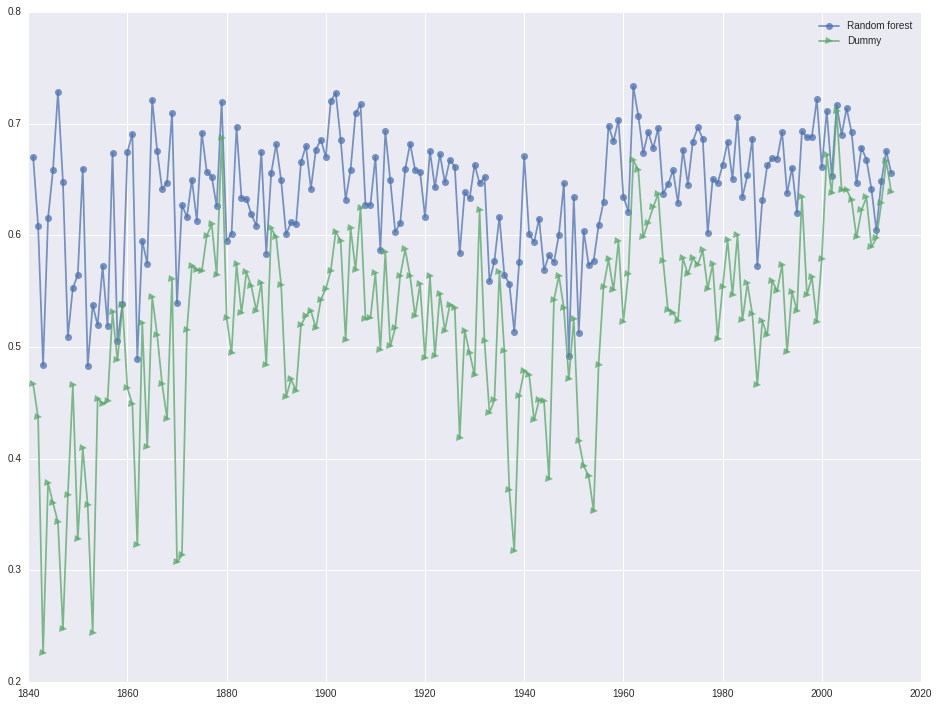

In [20]:
# Setup time series
rf_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct"].mean()
dummy_correct_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_ts.index, rf_correct_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_ts.index, dummy_correct_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

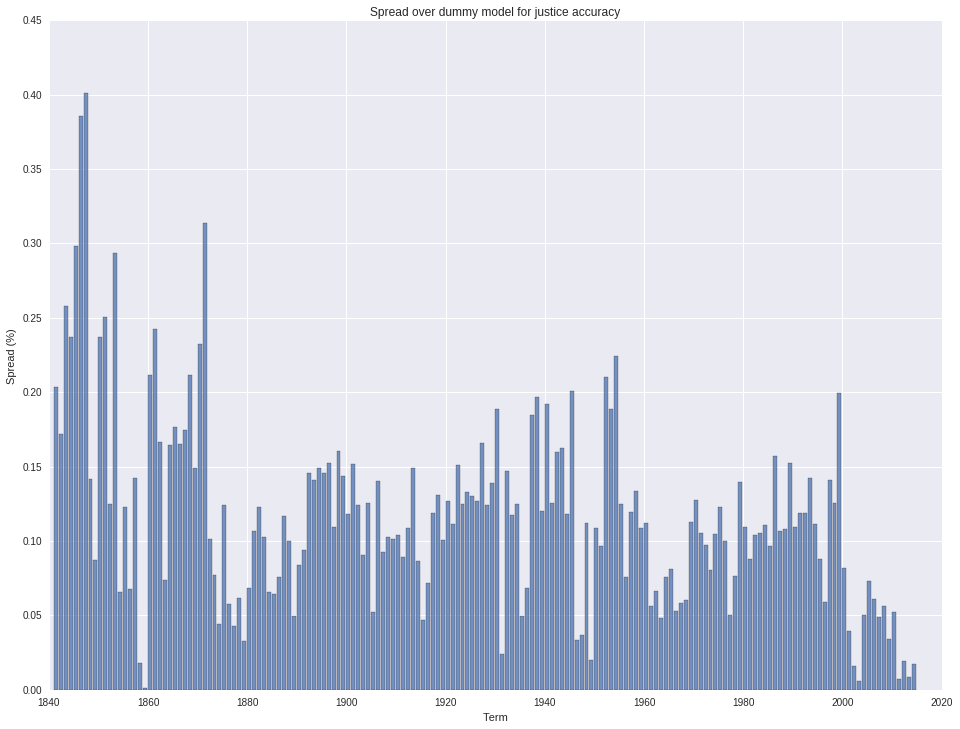

In [21]:
# Setup time series
rf_spread_ts = rf_correct_ts - dummy_correct_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_ts.index, rf_spread_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for justice accuracy")

In [22]:
# Feature importance
feature_importance_df = pandas.DataFrame(list(zip(feature_df.columns, m.feature_importances_)),
                                         columns=["feature", "importance"])
feature_importance_df.sort_values(["importance"], ascending=False).head(10)

,feature,importance
1723,justice_previous_lc_direction_diff,0.029598
1724,justice_cumulative_lc_direction_diff,0.029517
355,decision_delay,0.024626
0,term_raw,0.016978
1711,justice_previous_action,0.016348
1503,issue_area_9,0.016056
1720,justice_cumulative_court_agreement,0.015828
1716,justice_cumulative_court_action_diff,0.015433
1712,justice_cumulative_action,0.015305
1719,justice_previous_court_agreement,0.014693


In [23]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_ts.values,
                   dummy_correct_ts.values))

print("=" * 16)
print("Binomial:")
print(statsmodels.stats.proportion.binom_test(raw_data.loc[evaluation_index, "rf_correct"].sum(),
                                              raw_data.loc[evaluation_index, "rf_correct"].shape[0],
                                              raw_data.loc[evaluation_index, "dummy_correct"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=23.439004560452695, pvalue=1.4071818806656708e-55)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=12.523924592819887, pvalue=5.5234938248284593e-36)
Binomial:
0.0


In [24]:
# Get case-level prediction
#scdb_data.loc[evaluation_index, "rf_predicted_case"] = 
rf_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["rf_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
rf_predicted_case.columns = ["rf_predicted_case"]

dummy_predicted_case = pandas.DataFrame(raw_data.loc[evaluation_index, :]\
    .groupby(["docketId"])["dummy_predicted"]\
    .agg(lambda x: x.value_counts().index[0]))
dummy_predicted_case.columns = ["dummy_predicted_case"]

# Set DFs
rf_predicted_case = raw_data[["docketId", "case_outcome_disposition", "rf_predicted"]].join(rf_predicted_case, on="docketId")
dumy_predicted_case = raw_data[["docketId", "dummy_predicted"]].join(dummy_predicted_case, on="docketId")

raw_data.loc[:, "rf_predicted_case"] = rf_predicted_case
raw_data.loc[:, "dummy_predicted_case"] = dumy_predicted_case

In [25]:
# Output case distribution
case_outcomes = raw_data.groupby(["docketId"])["case_outcome_disposition"].apply(lambda x: x.mode())
case_outcomes = case_outcomes.apply(lambda x: int(x) if type(x) in [numpy.float64] else None)
print(case_outcomes.value_counts())
print(case_outcomes.value_counts(normalize=True))

 0    13270
 1    11503
-1     3490
dtype: int64
 0    0.469518
 1    0.406999
-1    0.123483
dtype: float64


In [26]:
# Output comparison
# Evaluation range
evaluation_index = raw_data.loc[:, "term"].isin(term_range) & -raw_data.loc[:, "case_outcome_disposition"].isnull()
target_actual = raw_data.loc[evaluation_index, "case_outcome_disposition"]
target_predicted = raw_data.loc[evaluation_index, "rf_predicted_case"]
target_dummy = raw_data.loc[evaluation_index, "dummy_predicted_case"]

raw_data.loc[:, "rf_correct_case"] = numpy.nan
raw_data.loc[:, "dummy_correct_case"] = numpy.nan
raw_data.loc[evaluation_index, "rf_correct_case"] = (target_actual == target_predicted).astype(float)
raw_data.loc[evaluation_index, "dummy_correct_case"] = (target_actual == target_dummy).astype(float)

# Compare model
print("RF model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_predicted))
print(sklearn.metrics.confusion_matrix(target_actual, target_predicted))
print(sklearn.metrics.accuracy_score(target_actual, target_predicted))
print("="*32)
print("")

# Dummy model
print("Dummy model")
print("="*32)
print(sklearn.metrics.classification_report(target_actual, target_dummy))
print(sklearn.metrics.confusion_matrix(target_actual, target_dummy))
print(sklearn.metrics.accuracy_score(target_actual, target_dummy))
print("="*32)
print("")

RF model
             precision    recall  f1-score   support

       -1.0       0.79      0.73      0.76     27672
        0.0       0.64      0.74      0.69    111712
        1.0       0.66      0.55      0.60     97862

avg / total       0.67      0.66      0.66    237246

[[20083  5468  2121]
 [ 3562 82899 25251]
 [ 1879 41743 54240]]
0.662696104465

Dummy model
             precision    recall  f1-score   support

       -1.0       0.28      0.04      0.08     27672
        0.0       0.55      0.75      0.63    111712
        1.0       0.62      0.51      0.56     97862

avg / total       0.55      0.57      0.54    237246

[[ 1208 22270  4194]
 [ 1913 83444 26355]
 [ 1250 46218 50394]]
0.569223506403



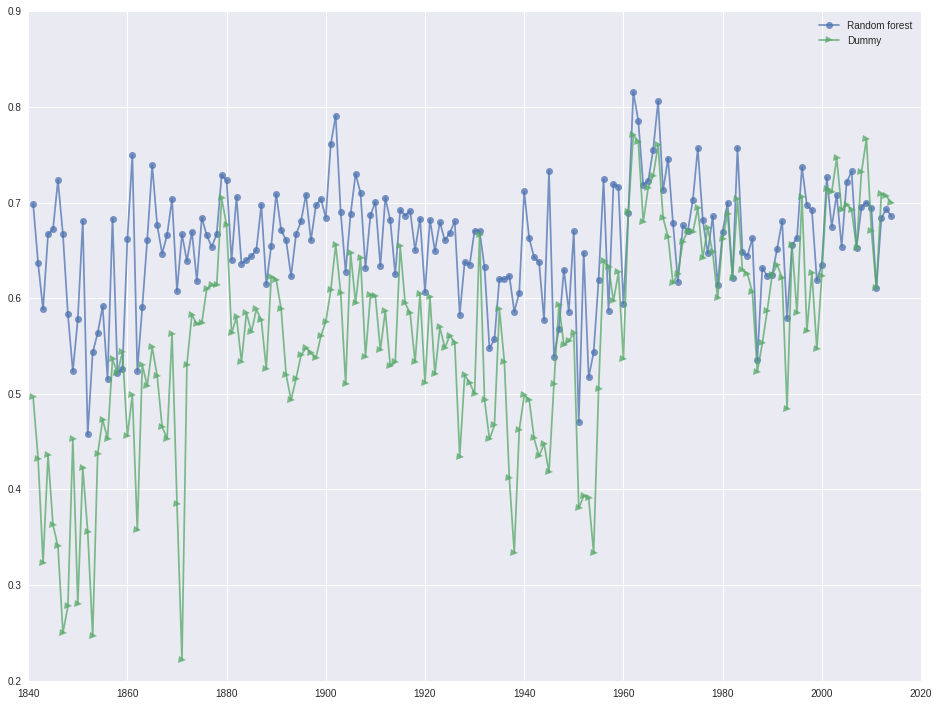

In [27]:
# Setup time series
rf_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["rf_correct_case"].mean()
dummy_correct_case_ts = raw_data.loc[evaluation_index, :].groupby("term")["dummy_correct_case"].mean()

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_correct_case_ts.index, rf_correct_case_ts,
         marker='o', alpha=0.75)
plt.plot(dummy_correct_case_ts.index, dummy_correct_case_ts,
         marker='>', alpha=0.75)
plt.legend(('Random forest', 'Dummy'))

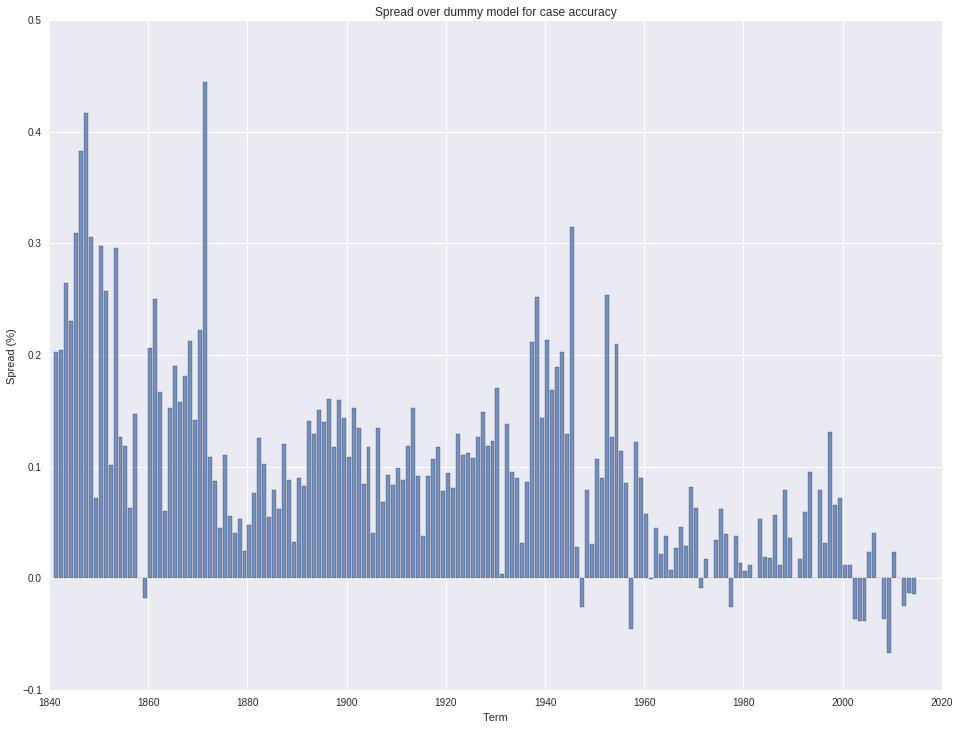

In [28]:
# Setup time series
rf_spread_case_ts = rf_correct_case_ts - dummy_correct_case_ts

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.bar(rf_spread_case_ts.index, rf_spread_case_ts,
        alpha=0.75)
plt.xlabel("Term")
plt.ylabel("Spread (%)")
plt.title("Spread over dummy model for case accuracy")

/data/workspace/scotus-predict-v2/env/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning: pd.expanding_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.expanding(min_periods=1).sum()
  from ipykernel import kernelapp as app


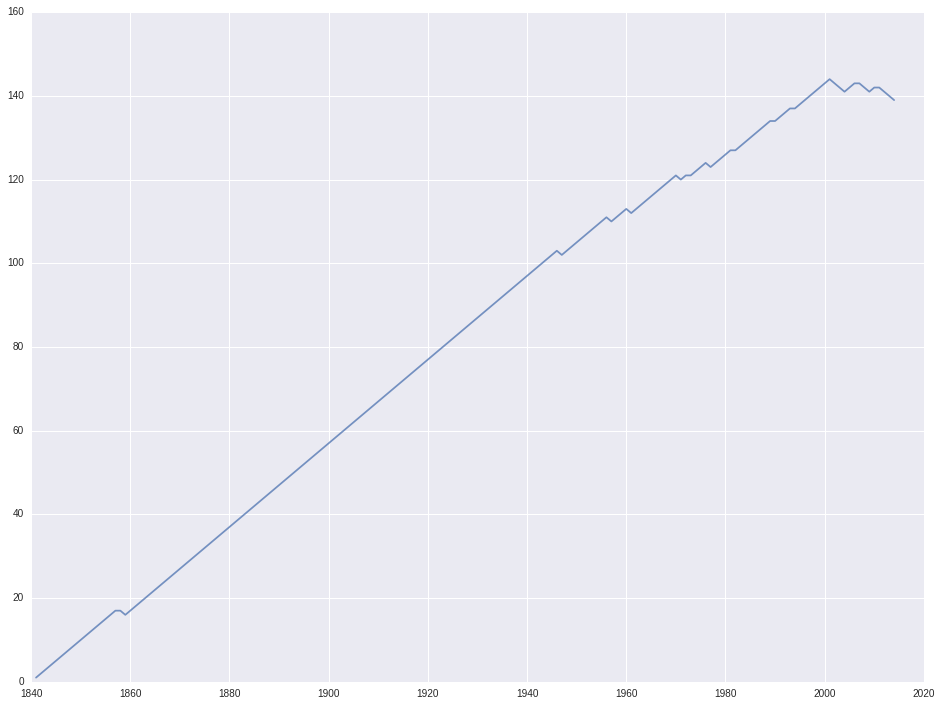

In [29]:
# Setup time series
rf_spread_case_dir_ts = pandas.expanding_sum(numpy.sign(rf_spread_case_ts))

# Plot all accuracies
f = plt.figure(figsize=(16, 12))
plt.plot(rf_spread_case_dir_ts.index, rf_spread_case_dir_ts,
        alpha=0.75)

In [30]:
# Output stats
print("t-test:")
print("Uncalibrated:")
print(scipy.stats.ttest_rel(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("ranksum-test:")
print("Uncalibrated:")
print(scipy.stats.ranksums(rf_correct_case_ts.values,
                   dummy_correct_case_ts.values))

print("=" * 16)
print("Binomial:")
case_accuracy_data = raw_data.loc[evaluation_index, ["docketId", "rf_correct_case", "dummy_correct_case"]].drop_duplicates()
print(statsmodels.stats.proportion.binom_test(case_accuracy_data["rf_correct_case"].sum(),
                                              case_accuracy_data["rf_correct_case"].shape[0],
                                              case_accuracy_data["dummy_correct_case"].mean(),
                                              alternative="larger"))

t-test:
Uncalibrated:
Ttest_relResult(statistic=14.410102802872732, pvalue=1.937494245127032e-31)
ranksum-test:
Uncalibrated:
RanksumsResult(statistic=9.021019543755985, pvalue=1.8634683648488082e-19)
Binomial:
1.2622296992e-213


In [31]:
raw_data.loc[raw_data.loc[:, "caseName"] == "MIRANDA v. ARIZONA", 
              ["caseName", "justiceName", "case_outcome_disposition", "justice_outcome_disposition",
              "rf_predicted", "rf_predicted_score_affirm", "rf_predicted_score_reverse", "rf_correct_case", "dummy_correct_case"]].T

,194698,194699,194700,194701,194702,194703,194704,194705,194706
caseName,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA,MIRANDA v. ARIZONA
justiceName,JHarlan2,HLBlack,WODouglas,PStewart,WJBrennan,BRWhite,EWarren,TCClark,AFortas
case_outcome_disposition,1,1,1,1,1,1,1,1,1
justice_outcome_disposition,0,1,1,0,1,0,1,0,1
rf_predicted,0,1,1,0,1,1,1,1,1
rf_predicted_score_affirm,0.511429,0.237143,0.145714,0.582857,0.305714,0.471429,0.177143,0.46,0.291429
rf_predicted_score_reverse,0.448571,0.731429,0.831429,0.382857,0.66,0.474286,0.728571,0.505714,0.548571
rf_correct_case,1,1,1,1,1,1,1,1,1
dummy_correct_case,1,1,1,1,1,1,1,1,1


In [40]:
# Output file data
file_timestamp = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
raw_data.to_csv("../data/output/scdb_legacy_raw_data_most_frequent_{0}.csv".format(file_timestamp))
case_accuracy_data.to_csv("../data/output/scdb_legacy_case_data_most_frequent_{0}.csv".format(file_timestamp))